In [1]:
%load_ext autoreload
%autoreload 2

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
import torch

from inxss import calc_Sqw_from_SpinW_results

In [2]:
pathname = '/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Sep13'
all_csv = np.array([_.split('/')[-1] for _ in sorted(glob.glob(os.path.join(pathname, '*.csv')))])

startwith_Syy_wB = np.array([_.startswith('Syy_withBroadening') for _ in all_csv])
startwith_Szz_wB = np.array([_.startswith('Szz_withBroadening') for _ in all_csv])

In [3]:
Syy_csv = all_csv[startwith_Syy_wB]
Syy_csv = Syy_csv[np.argsort([int(re.split('[_ .]', _)[-2]) for _ in Syy_csv])]
Szz_csv = all_csv[startwith_Szz_wB]
Szz_csv = Szz_csv[np.argsort([int(re.split('[_ .]', _)[-2]) for _ in Szz_csv])]

In [4]:
print("# of Syy files: ", len(Syy_csv))
print("# of Szz files: ", len(Szz_csv))

# of Syy files:  600
# of Szz files:  600


In [5]:
q_grid = np.loadtxt(os.path.join(pathname, 'Qlist_1.csv'), delimiter=',')
w_grid_edges = np.loadtxt(os.path.join(pathname, 'Elist_1.csv'), delimiter=',')
w_grid = (w_grid_edges[1:] + w_grid_edges[:-1]) / 2
params = np.loadtxt(os.path.join(pathname, 'parameters.csv'), delimiter=',', skiprows=1)[:len(Syy_csv),1:]

In [6]:
Syy = torch.zeros((len(Syy_csv), ) + (w_grid.shape[0], q_grid.shape[1]))
Szz = torch.zeros((len(Syy_csv), ) + (w_grid.shape[0], q_grid.shape[1]))
Sqw = torch.zeros((len(Syy_csv), ) + (w_grid.shape[0], q_grid.shape[1]))

In [7]:
for _i, (_Syy_csv, _Szz_csv) in tqdm(enumerate(zip(Syy_csv, Szz_csv)), total=len(Syy_csv)):
    Syy[_i] = torch.from_numpy(np.loadtxt(os.path.join(pathname, _Syy_csv), delimiter=','))
    Szz[_i] = torch.from_numpy(np.loadtxt(os.path.join(pathname, _Szz_csv), delimiter=','))
    Sqw[_i] = torch.from_numpy(calc_Sqw_from_SpinW_results(q_grid, Syy[_i].numpy(), Szz[_i].numpy()))

100%|██████████| 600/600 [05:01<00:00,  1.99it/s]


In [8]:
torch.save(
    {
        'Syy': Syy,
        'Szz': Szz,
        'S': Sqw,
        'w_grid': torch.from_numpy(w_grid),
        'q_grid': torch.from_numpy(q_grid),
        'params': torch.from_numpy(params)
    }, '/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Sep13.pt'
)

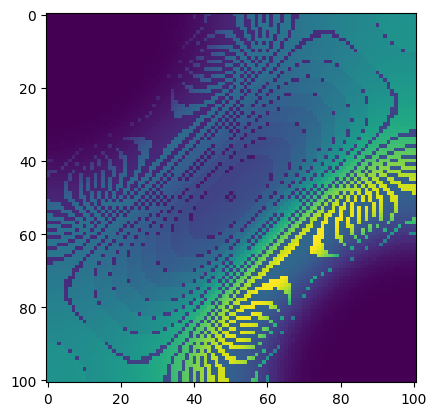

In [9]:
plt.imshow(Sqw.reshape(-1,101,101)[100])